In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import scipy as sp
from IPython.display import Image

## Shooting method (XI.9.16) 

$ x''=1-e^x, x(0)=x(120)=0, x'(0)=x'(12)=A \geq 10 $

In [3]:
def f_calc_d2(x):
    return 1-np.exp(x)

def f_calc_d1(x):
    x, dx = x
    return np.array((dx, f_calc_d2(x)))

In [14]:
def runge_kutt_iter(y0, h, f_calc): 
    ## one step of modified Euler's method with correction
    y1 = y0 + h * f_calc(y0)
    y1 = y0 + (h/2 * (f_calc(y0)+f_calc(y1)))
    return y1

def calc_bdf(tmin, tmax, x0, n, f_calc):
    h = (tmax - tmin)/n
    t = np.linspace(tmin, tmax, n+1, endpoint=True)
    dim = len(x0)
    y = np.zeros((n+1, dim))
    y[0] = x0
    y[1] = runge_kutt_iter(y[0], h, f_calc)
    for i in range(2, n+1):
        to_solve = lambda yi: -yi + (4/3) * y[i-1] - (1/3) * y[i-2] + (2/3) * h * f_calc(yi)
        y[i] = sp.optimize.fsolve(to_solve, y[i-1])
    return t, y

#### General example of solutions

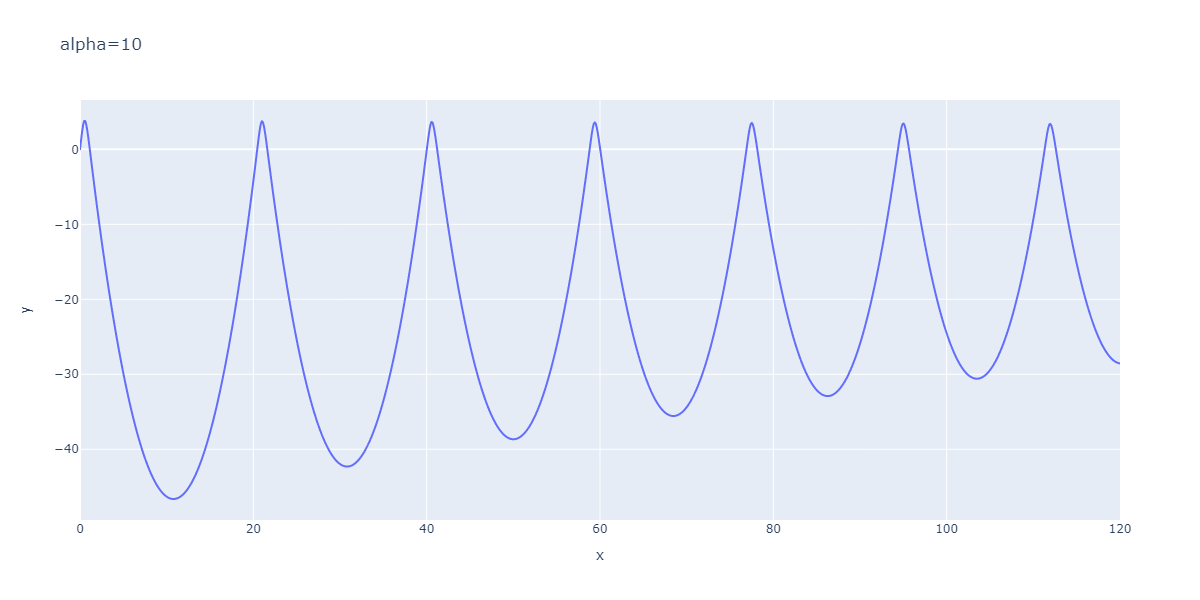

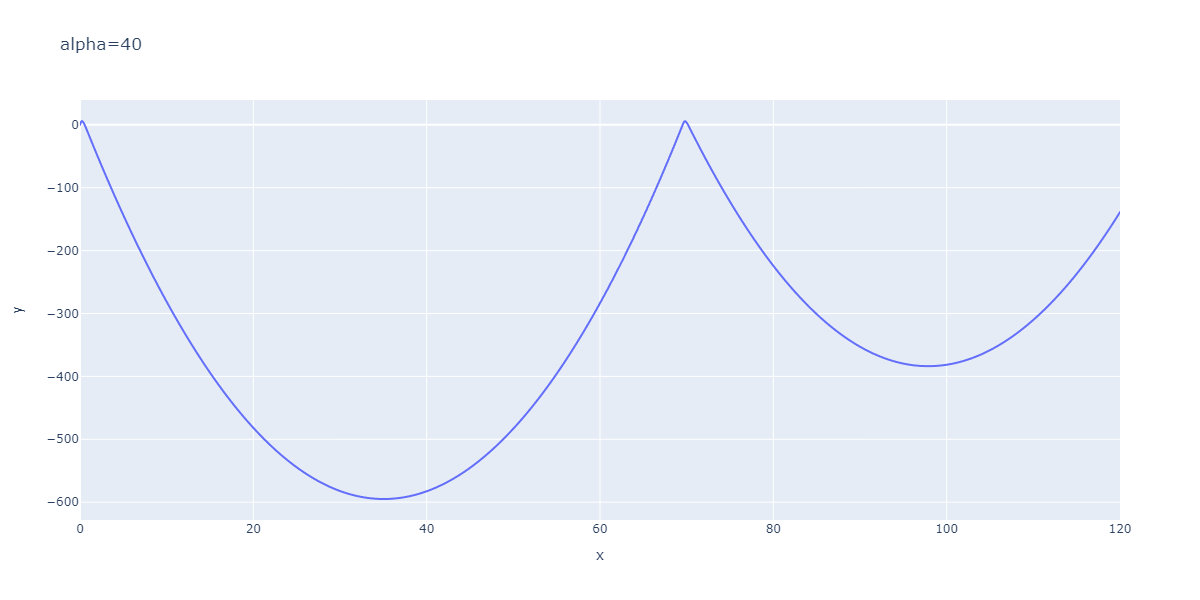

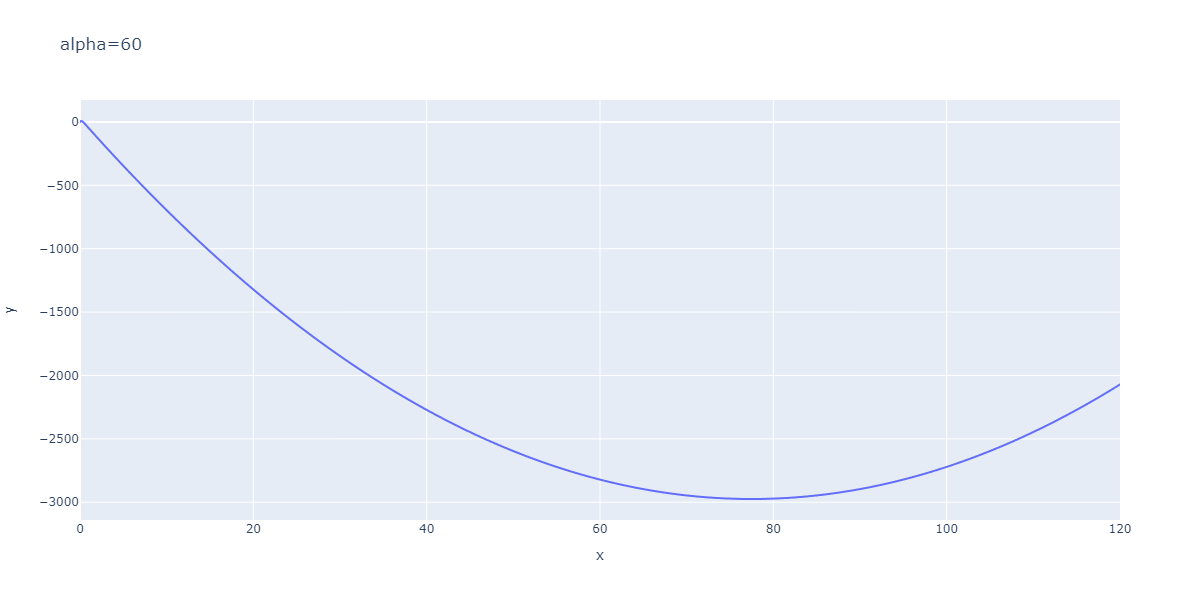

In [238]:
for alpha in [10, 40, 60]:
    t,y = calc_bdf(0, 120, np.array((0, alpha)), 1000, f_calc_d1)
    res = y[:, 0]
    fig = px.line(x=t, y=res, title=f'{alpha=}')
    display(Image(fig.to_image(format="png", width=1200, height=600, scale=1)))

In [56]:
def find_last_root_pos_df(arr, atol=1):
    # finds the most right root with positive derivative
    roots = np.where(np.isclose(arr, 0, atol=atol))[0]
    if len(roots)==1:
        return 0
    for ind in roots[::-1]:
        if ind==len(arr)-1:
            deriv = arr[ind]-arr[ind-1]
        else:
            deriv = (arr[ind+1]-arr[ind-1])/2
        if deriv>0:
            return ind
    return 0

In [79]:
def find_all_a(alpha0=60):
    good_a = []
    roots = []
    for alpha in range(alpha0, 9, -1):
        res = calc_bdf(0, 120, np.array((0, alpha)), 1000, f_calc_d1)[1][:, 0]
        # print(f'{a=}, {find_last_root_pos_df(res)}')
        roots.append(find_last_root_pos_df(res))
        if find_last_root_pos_df(res)>950:
            good_a.append(alpha)
        # px.line(y=res, title=str(alpha)).show()
    return good_a

#### First approximations of solutions

In [81]:
ans = find_all_a()
ans

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



[38, 37, 26, 25, 18, 14, 11]

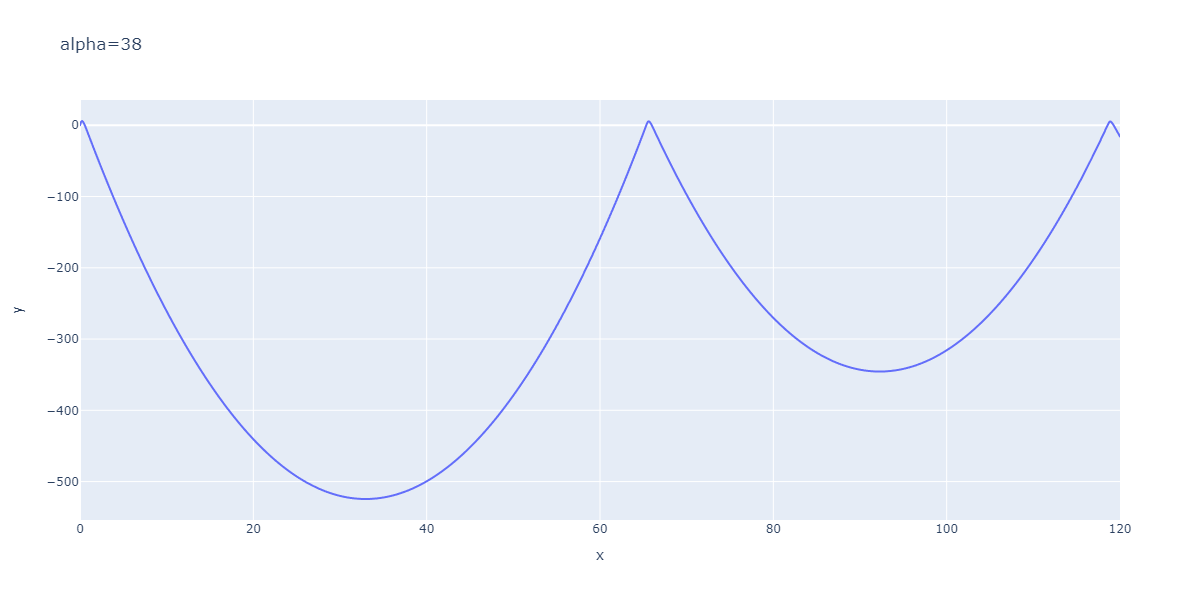

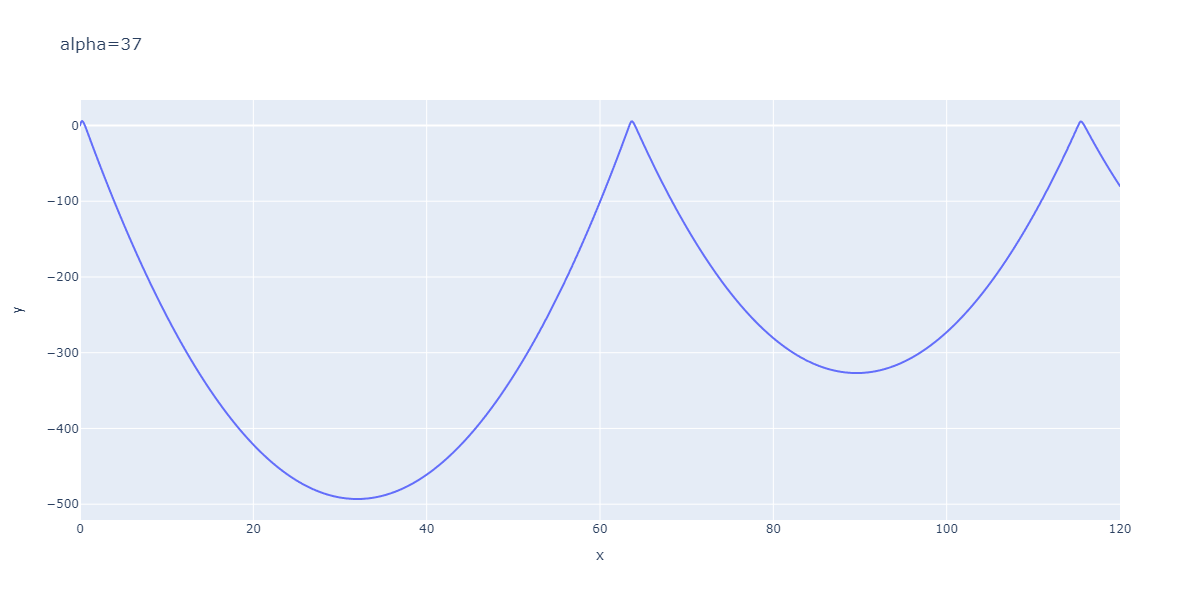

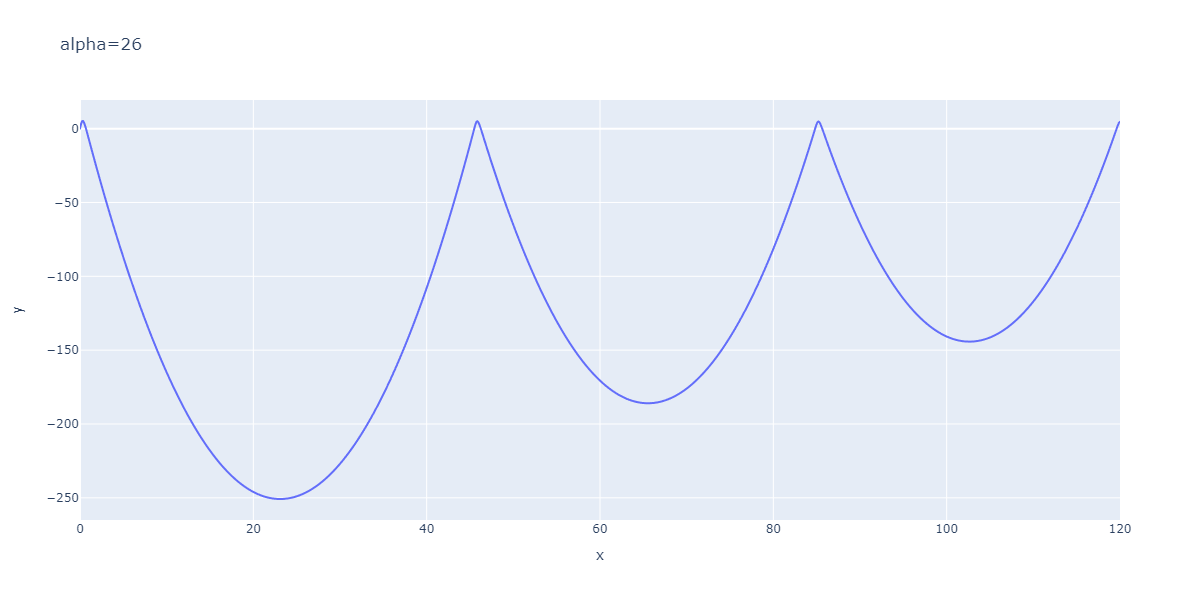

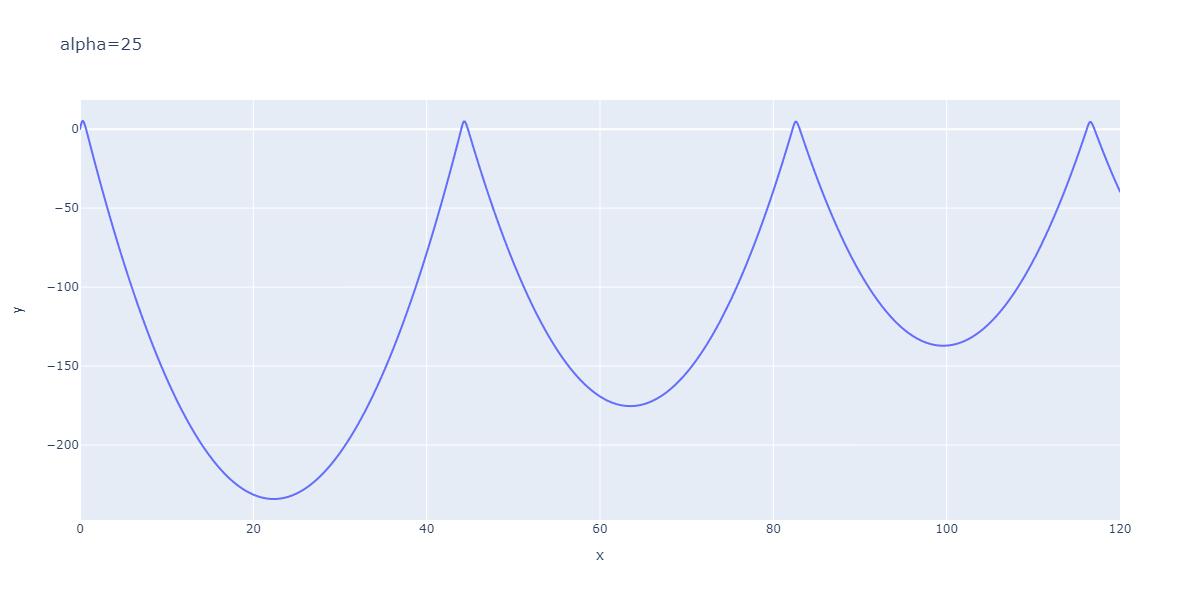

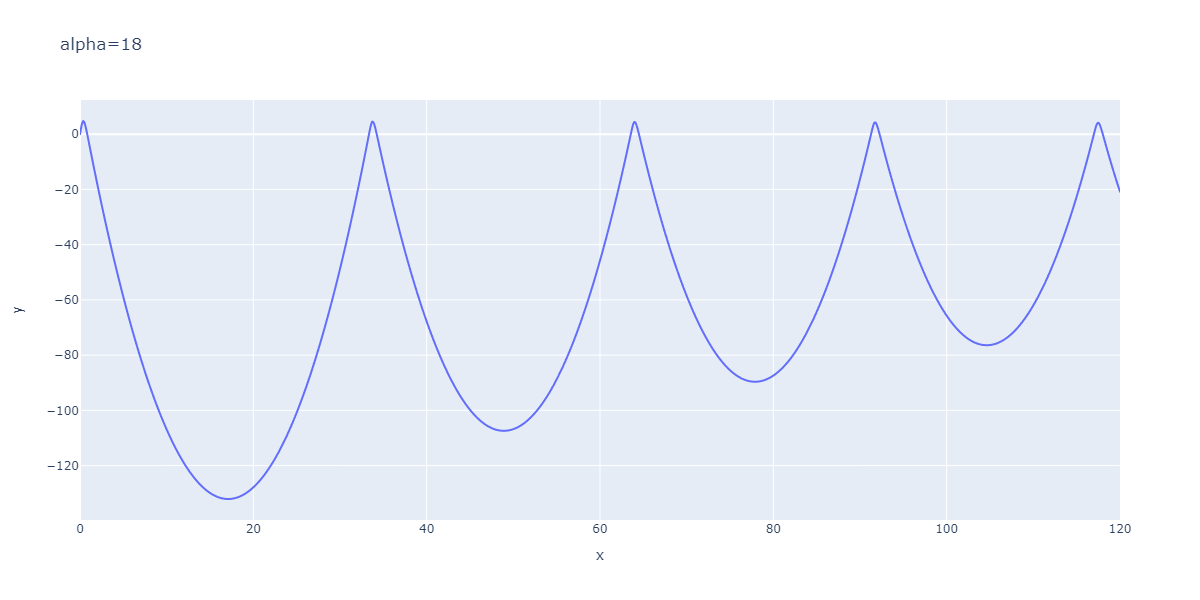

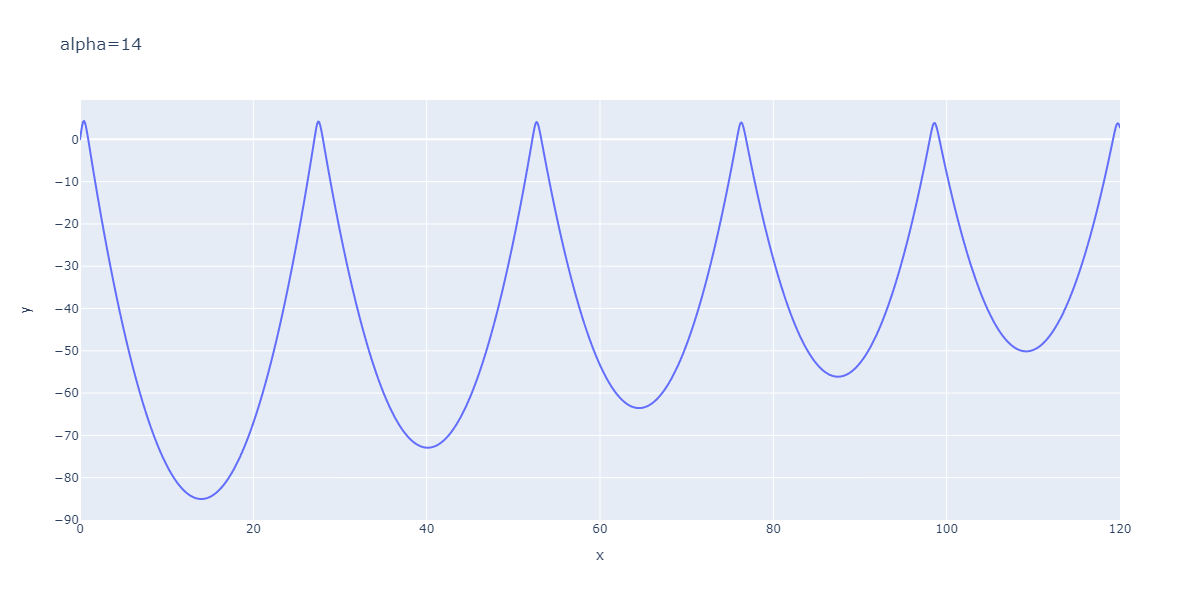

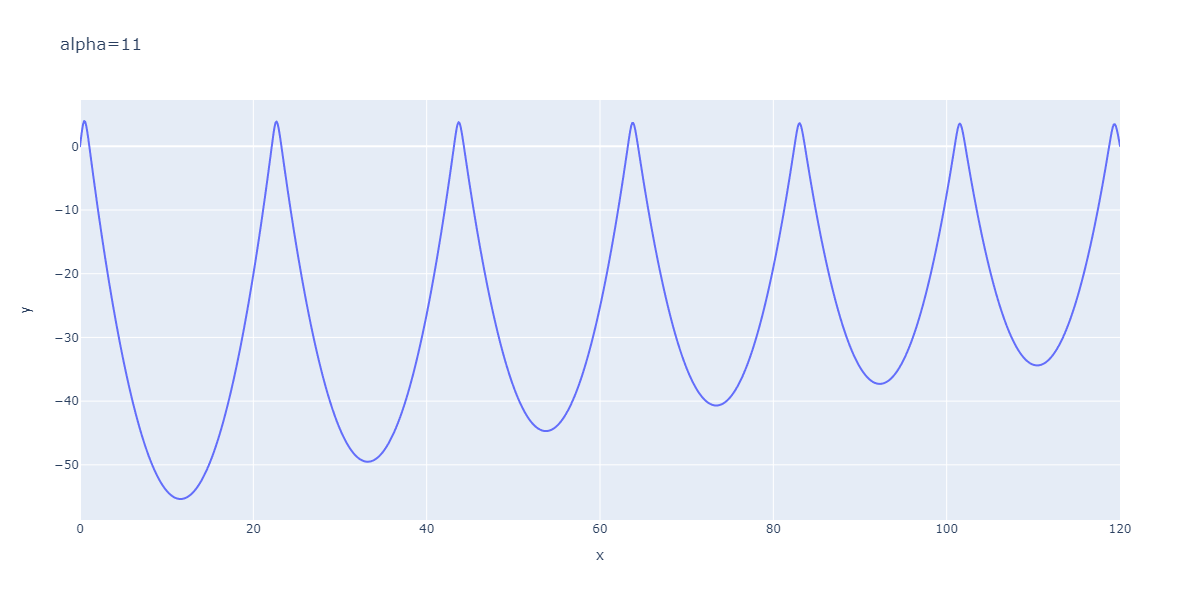

In [239]:
for alpha in ans:
    t, y = calc_bdf(0, 120, np.array((0, alpha)), 1000, f_calc_d1)
    res = y[:, 0]
    fig = px.line(x=t, y=res, title=f'{alpha=}')
    display(Image(fig.to_image(format="png", width=1200, height=600, scale=1)))

#### Correction

In [102]:
def bsearch_a(la, ra):
    lpos = find_last_root_pos_df(
        calc_bdf(0, 120, np.array((0, la)), 1000, f_calc_d1)[1][:, 0]
    )
    if lpos>997:
        return la
    rpos = find_last_root_pos_df(
        calc_bdf(0, 120, np.array((0, ra)), 1000, f_calc_d1)[1][:, 0]
    )
    if rpos>997:
        return ra
    if rpos > lpos: 
        print(ra, la, rpos, lpos)
        raise Exception('your boundaries are on the same side')
    ha = (ra+la)/2
    hpos = find_last_root_pos_df(
        calc_bdf(0, 120, np.array((0, ha)), 1000, f_calc_d1)[1][:, 0]
    )
    print(la, ra, lpos, rpos, ha, hpos)
    if hpos < 950: # too big period~a
        return bsearch_a(la, ha)
    return bsearch_a(ha, ra) # too small period~a

In [103]:
alphas = [38, 26, 18, 14, 11] # some are dropped because dupliactes
corrected = [] 
for alpha in alphas:
    corrected.append(bsearch_a(alpha, alpha+2))
print(corrected)

38 40 988 0 39.0 0
38 39.0 988 0 38.5 553
38 38.5 988 553 38.25 995
38.25 38.5 995 553 38.375 551
38.25 38.375 995 551 38.3125 996
38.3125 38.375 996 551 38.34375 997
38.34375 38.375 997 551 38.359375 998
26 28 997 750 27.0 728
26 27.0 997 728 26.5 718
26 26.5 997 718 26.25 712
26 26.25 997 712 26.125 1000
18 20 975 822 19.0 792
18 19.0 975 792 18.5 994
18.5 19.0 994 792 18.75 784
18.5 18.75 994 784 18.625 998
14 16 994 898 15.0 858
14 15.0 994 858 14.5 838
14 14.5 994 838 14.25 828
14 14.25 994 828 14.125 1000
11 13 990 945 12.0 894
11 12.0 990 894 11.5 868
11 11.5 990 868 11.25 855
11 11.25 990 855 11.125 998
[38.359375, 26.125, 18.625, 14.125, 11.125]


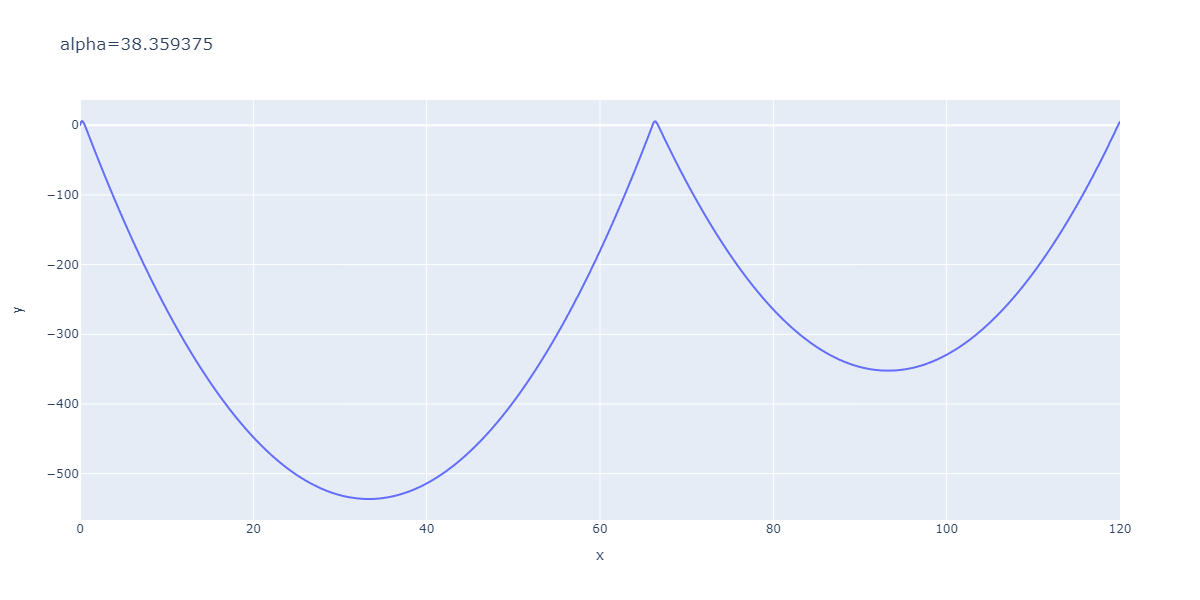

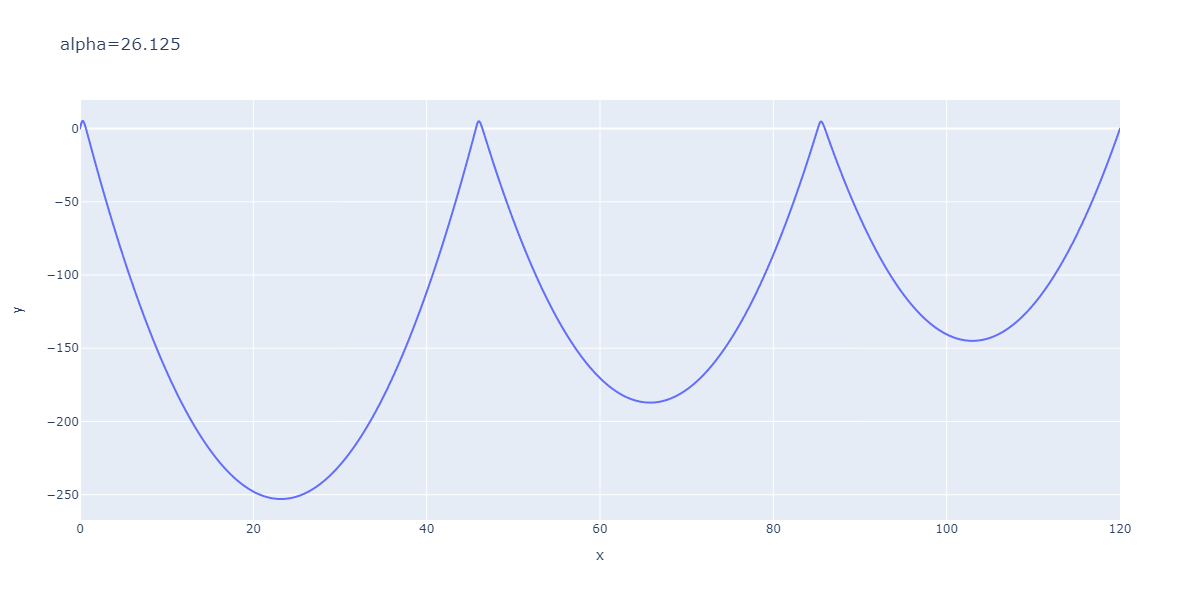

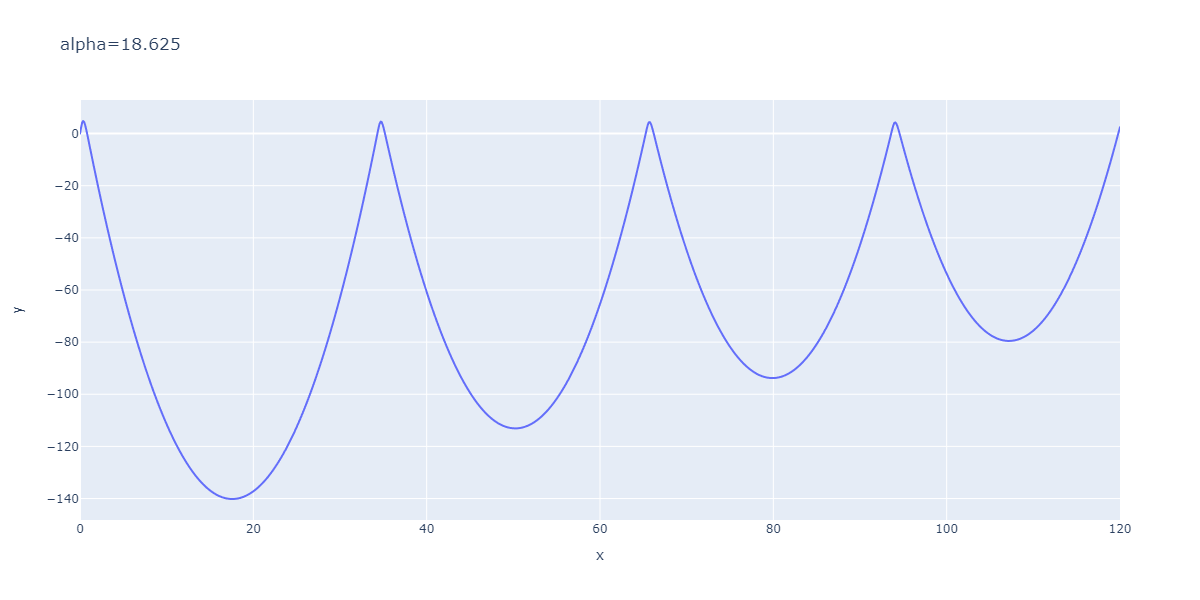

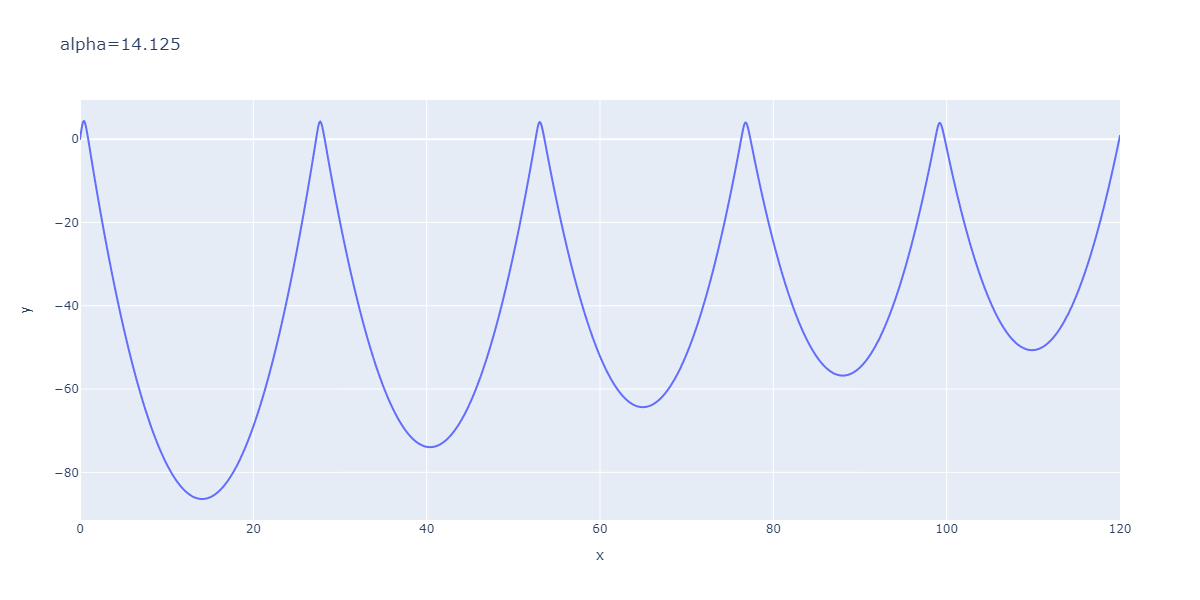

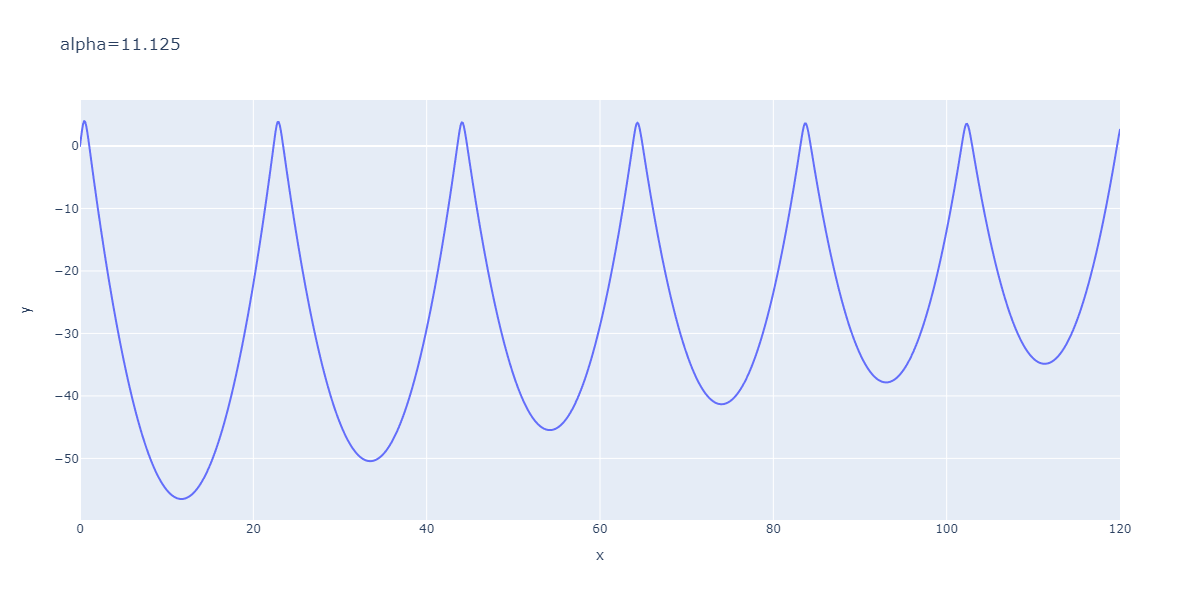

In [240]:
for alpha in corrected:
    t,y = calc_bdf(0, 120, np.array((0, alpha)), 1000, f_calc_d1)
    res = y[:, 0]
    fig = px.line(x=t, y=res, title=f'{alpha=}')
    display(Image(fig.to_image(format="png", width=1200, height=600, scale=1)))

# Tridiagonal matrix algorithm (XI.9.5)

![Alt text](task95.png)

In [55]:
def psq(x):
    return 10 + np.sin(2*np.pi*x)

def f(x):
    return np.cos(2*np.pi*x)

N = 200
h = 1/N
h

0.005

#### Filling matrix

![Alt text](tridiag_matrix.png)

where p=0, q=-P^2

In [56]:
xs = np.linspace(0, 1, N+2)[:-1]
phi = f(xs)*h**2
a = 1 - 0.5*h*np.zeros(N+2)[:-1] # p=0
c = 1 + 0.5*h*np.zeros(N+2)[:-1] # p=0
b = 2 + h**2 * psq(xs)
phi[-1]/h**2, phi[0]/h**2, len(phi), np.linspace(0, 1, N+2)[-1], np.linspace(0, 1, N+2)[-2]

(0.9995114576004659, 1.0, 201, 1.0, 0.9950248756218906)

### Numpy exact solution of matrix for check

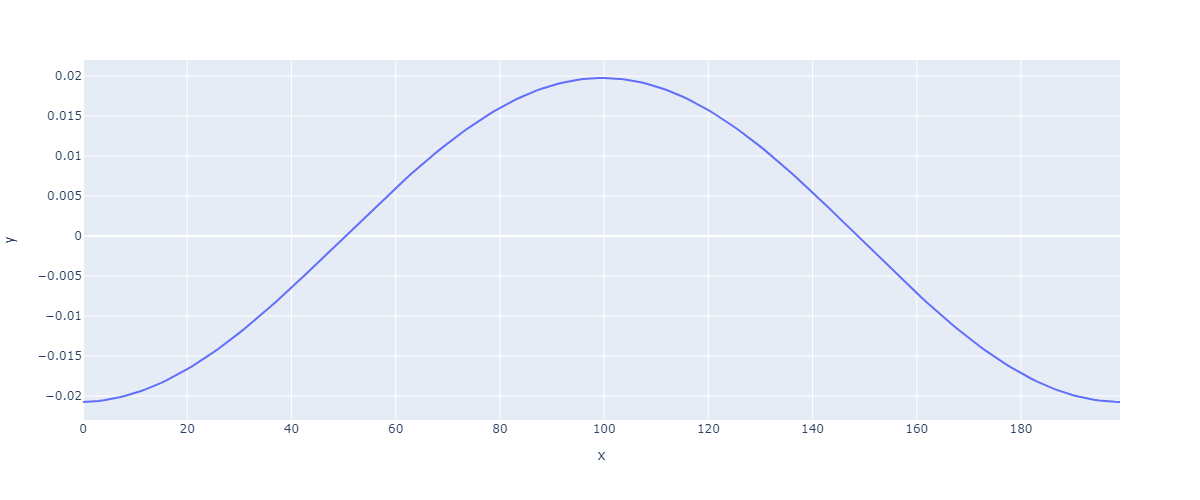

In [57]:
mat = np.zeros((N, N))
xs = np.linspace(0, 1, N)
f_v = f(xs)
for n in range(0, N):
    mat[n, (n+1)%N] = 1/h**2
    mat[n, (n-1)%N] = 1/h**2
    mat[n, n] = -2/h**2 - psq(n*h)
ans = np.linalg.solve(mat, f_v)
fig = px.line(y=ans, height=800)
display(Image(fig.to_image(format="png", width=1200, height=500, scale=1)))

#### Solving general tridiagonal
![Alt text](abc.png)

In [58]:
alpha = np.zeros(N+2)
alpha[0] = np.NAN
betta = np.zeros(N+2)
betta[0] = np.NAN
gamma = np.zeros(N+2)
gamma[0] = np.NAN

alpha[1] = c[0]/b[0]
betta[1] = -phi[0]/b[0]
gamma[1] = a[0]/b[0]
for k in range(1, len(alpha)-1):
    alpha[k+1] = c[k]/(b[k]-alpha[k]*a[k])
    betta[k+1] = (a[k]*betta[k]-phi[k])/(b[k]-alpha[k]*a[k])
    gamma[k+1] = a[k]*gamma[k]/(b[k]-alpha[k]*a[k])

![Alt text](munu.png)

In [59]:
mu = np.zeros(N+1)
nu = np.zeros(N+1)
mu[N] = -c[N] /(a[N]*(alpha[N]+gamma[N])-b[N])
nu[N] = (phi[N]-a[N]*betta[N]) /(a[N]*(alpha[N]+gamma[N])-b[N])
for n in range(len(mu)-1, 0, -1):
    mu[n-1] = alpha[n]*mu[n] + gamma[n]*mu[N]
    nu[n-1] = betta[n] + alpha[n]*nu[n] + gamma[n]*nu[N]

In [60]:
y = np.zeros(N+1)
y[0] = nu[0]/(1-mu[0])
y[N] = mu[N] * y[0] + nu[N]
for n in range(2, len(y)):
    y[n-1] = alpha[n] * (mu[n] * y[0] + nu[n]) + betta[n] + gamma[n] * (mu[N] * y[0] + nu[N])

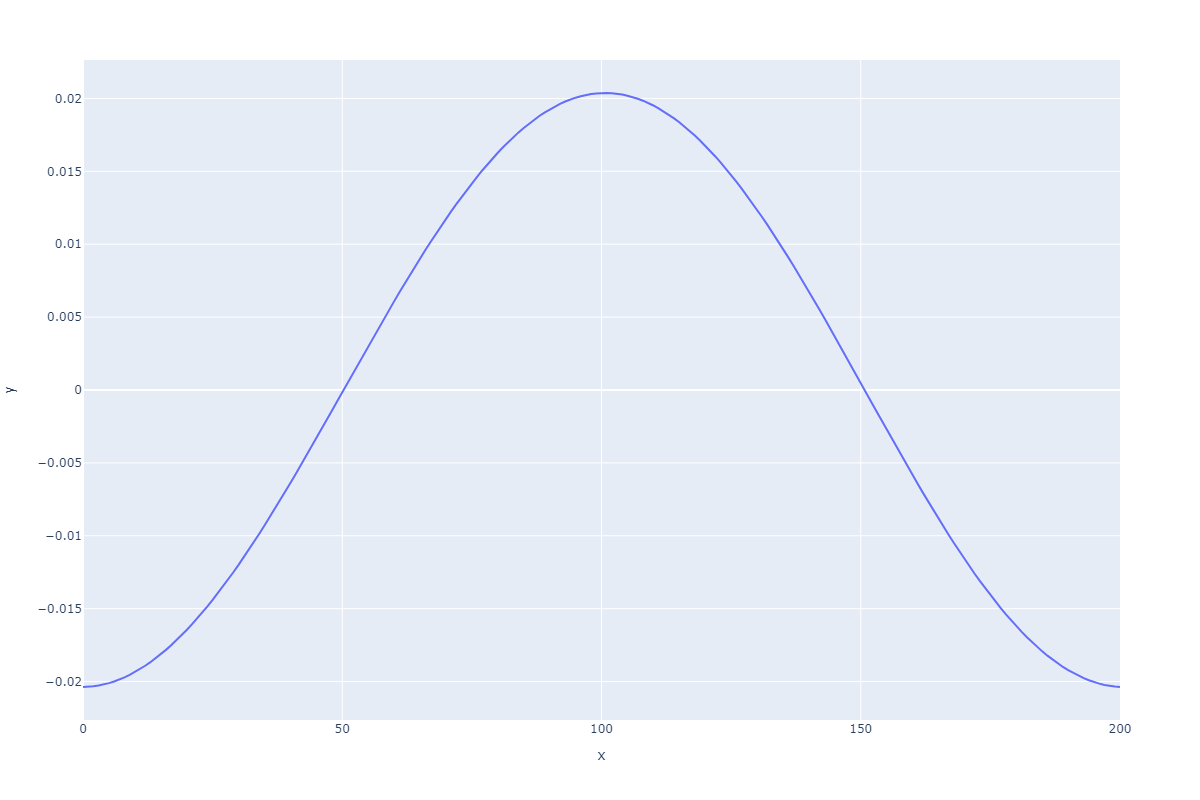

In [61]:
fig = px.line(y=y, height=800)
display(Image(fig.to_image(format="png", width=1200, height=800, scale=1)))